In [40]:
import os
import pandas as pd
import pickle

x = list(os.walk('../dogImages/train'))

x.remove(x[0])

mapping = {}
for folder in x:
    mapping[folder[0].split('\\')[-1].split('.')[-1]] = len(folder[-1])

In [4]:
df = pd.DataFrame.from_dict(mapping, orient = 'index', columns = ['train_count'])\
                            .reset_index().rename({'index':'Breed'}, axis = 1)

df['Breed']=df['Breed'].apply(lambda x : x.replace('_',' '))

In [39]:
df_bottom_4 = df.sort_values(['train_count'], ascending = True)[:4]
df_top_4 = df.sort_values(['train_count'], ascending = True)[-4:]
df_diff = pd.concat([df_bottom_4,df_top_4])
df_diff.to_pickle('model/Breed_Counts.pkl')

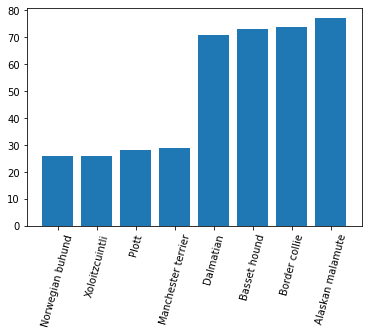

In [37]:
import matplotlib.pyplot as plt

plt.bar(df_diff.Breed, df_diff.train_count)
plt.xticks(rotation = 75)
plt.show()

In [7]:
import cv2

train_filepath = '../dogImages/train'
Malamute_index = df[df.Breed == 'Alaskan malamute'].index[0]

Malamute_folder_name = os.listdir(train_filepath)[Malamute_index]
Malamute_folder = os.path.join(train_filepath,Malamute_folder_name)

Malamute_img_names = os.listdir(Malamute_folder)
Malamute_img_paths = [os.path.join(train_filepath,Malamute_folder_name, filename) for filename in Malamute_img_names]

Malamute_imgs = [cv2.imread(image_path) for image_path in Malamute_img_paths]


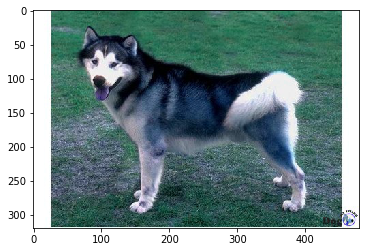

In [8]:
plt.imshow(Malamute_imgs[25])

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions,ResNet50
from keras.preprocessing import image
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.datasets import load_files 
from glob import glob
import numpy as np
import random
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

def face_detector(img_path):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets


train_files, train_targets = load_dataset('../dogImages/train')
human_files = np.array(glob("../lfw/*/*"))
random.shuffle(human_files)

Using TensorFlow backend.


In [10]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_count = 0
human_dogface_count = 0
dog_count = 0
dog_humanface_count =0

incorrect_dog = []
incorrect_human = []

for human in human_files_short:
    if dog_detector(human):
        human_dogface_count += 1
        incorrect_dog.append(human)
        
    if face_detector(human):
        human_count += 1

dog_count = 0
for dog in dog_files_short:
    if dog_detector(dog):
        dog_count += 1
        
    if face_detector(dog):
        dog_humanface_count +=1
        incorrect_human.append(dog)
        
        
human_dog_accuracy = float(human_dogface_count) / float(len(human_files_short))
dog_dog_accuracy = float(dog_count) / float(len(dog_files_short))
human_dog_accuracy = "{0:.0%}".format(human_dog_accuracy)
dog_dog_accuracy = "{0:.0%}".format(dog_dog_accuracy)

human_human_accuracy = float(human_count) / float(len(human_files_short))
dog_human_accuracy = float(dog_humanface_count) / float(len(dog_files_short))
human_human_accuracy = "{0:.0%}".format(human_human_accuracy)
dog_human_accuracy = "{0:.0%}".format(dog_human_accuracy)



print("The dog detector incorrectly guessed %s of humans as a dog."%(human_dog_accuracy))    
print("The dog detector correctly guessed %s of dog faces."%(dog_dog_accuracy))
print("The face detector incorrectly guessed %s of dogs as humans."%(dog_human_accuracy))    
print("The face detector correctly guessed %s of human faces."%(human_human_accuracy))

The dog detector incorrectly guessed 0% of humans as a dog.
The dog detector correctly guessed 100% of dog faces.
The face detector incorrectly guessed 12% of dogs as humans.
The face detector correctly guessed 98% of human faces.


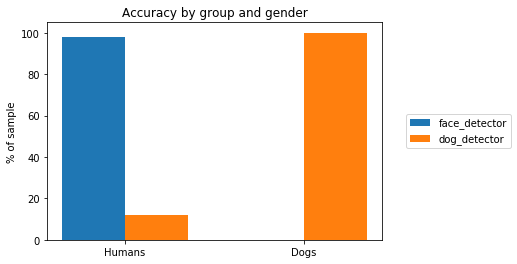

In [44]:
human_vals = (human_count, human_dogface_count)
dog_vals = (dog_humanface_count, dog_count)
pickle.dump([human_vals,dog_vals],open('model/BarChart_1.pkl','wb+'))

fig, ax = plt.subplots()

ind = np.arange(2)    
width = 0.35

p1 = ax.bar(ind, human_vals, width,label='face_detector')
p2 = ax.bar(ind + width, dog_vals, width,label='dog_detector')

ax.set_title('Accuracy by group and detector type')
ax.set_ylabel('% of sample')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Humans', 'Dogs'))
ax.legend(loc='center right',bbox_to_anchor=(1.4, 0.50))

In [10]:
incorrect_human_img = [cv2.imread(file) for file in incorrect_human]
incorrect_dog_img = [cv2.imread(file) for file in incorrect_dog] #this is empty, i.e. no humans were classified as dogs

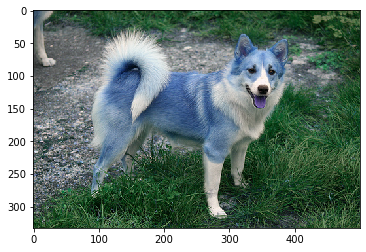

In [11]:
plt.imshow(incorrect_human_img[11])
#index 0: multiple dogs
#index 3: Dalmation patterns, also not clear / other bodies in the image
#index 5: Both a human and a dog in this photo
#index 6: Unclear/obscured face
#index 7: Multiple dogs
#index 9: Multiple dogs and dalmatian patterns
#index 10: Multiple dogs / edited image

In [38]:
##########################################################
if os.getcwd().split('\\')[-1] != 'model':
    os.chdir('model')
    
from model.prediction import *
os.chdir('..')
breeds = [item[20:-1] for item in sorted(glob("../dogImages/train/*/"))]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
#predictions = [model_predict(img, breeds) for img in train_files[:1000]]
#predictions = []
files = [ent[0] for ent in  predictions]
for img in train_files:
    if img not in files and img != '../dogImages/train\\098.Leonberger\\Leonberger_06571.jpg':
        predictions.append((img,model_predict(img,breeds)))

In [ ]:
actuals = [convert_to_label(targ, breeds) for targ in train_targets]

In [14]:
predictions

NameError: name 'predictions' is not defined

In [17]:
predictions

[('../dogImages/train\\095.Kuvasz\\Kuvasz_06442.jpg', 'Kuvasz'),
 ('../dogImages/train\\057.Dalmatian\\Dalmatian_04054.jpg', 'Dalmatian'),
 ('../dogImages/train\\088.Irish_water_spaniel\\Irish_water_spaniel_06014.jpg',
  'Irish_water_spaniel'),
 ('../dogImages/train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00596.jpg',
  'American_staffordshire_terrier'),
 ('../dogImages/train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00563.jpg',
  'American_staffordshire_terrier'),
 ('../dogImages/train\\063.English_springer_spaniel\\English_springer_spaniel_04469.jpg',
  'English_springer_spaniel'),
 ('../dogImages/train\\054.Collie\\Collie_03789.jpg', 'Collie'),
 ('../dogImages/train\\119.Petit_basset_griffon_vendeen\\Petit_basset_griffon_vendeen_07705.jpg',
  'Petit_basset_griffon_vendeen'),
 ('../dogImages/train\\009.American_water_spaniel\\American_water_spaniel_00625.jpg',
  'American_water_spaniel'),
 ('../dogImages/train\\081.Greyhound\\Greyh

In [19]:
img

'../dogImages/train\\098.Leonberger\\Leonberger_06571.jpg'

In [2]:
predictions

NameError: name 'predictions' is not defined

In [36]:
####################################################